## BLB Games EDA

This notebook will explore the characteristics of the games data, independent of any deck analysis or card information. Quick questions like - how many total drafts are represented? How many are incomplete (don't get to 7 wins or 3 losses).

In [3]:
%load_ext autoreload
%autoreload 2


#Imports
import pandas as pd


## Temp Code

Struggling with script files, copying in here to move forward

In [4]:
#TODO clean this up
games_dfmap = {}
import os
def get_games_data(set_code: str):
    """Retrieves games data, prioritizing cached data, then Parquet, and finally CSV."""
    if set_code in games_dfmap:
        return games_dfmap[set_code]

    parquet_file = f"data/{set_code}/games.parquet"
    csv_file = f"data/{set_code}/games.csv"

    if os.path.exists(parquet_file):
        print(f"Loading game data for {set_code} from Parquet file...")
        #df = pd.read_parquet(parquet_file, engine="pyarrow")
        df = pd.read_parquet(parquet_file, engine='fastparquet')
        games_dfmap[set_code] = df
        return df

    if os.path.exists(csv_file):
        print(f"Reading and converting data for {set_code} to Parquet...")
        df = convert_to_parquet_(set_code)
        games_dfmap[set_code] = df
        return df
    
    raise FileNotFoundError(f"No data found (CSV or parquet) for set: {set_code}")
    
def convert_to_parquet_(set_code: str):
    """Converts the games CSV file to Parquet format for efficient storage and retrieval."""
    csv_file = f"data/{set_code}/games.csv"
    parquet_file = f"data/{set_code}/games.parquet"

    if os.path.exists(parquet_file):
        print(f"Parquet file {parquet_file} already exists. No conversion needed.")
        return games_dfmap.get(set_code, pd.read_parquet(parquet_file, engine="pyarrow"))

    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"CSV file {csv_file} does not exist.")

    df = pd.read_csv(csv_file)
    df.to_parquet(parquet_file, engine="pyarrow", compression="snappy")  # Snappy is fast & efficient
    print(f"Converted {csv_file} to {parquet_file}.")
    
    games_dfmap[set_code] = df
    return df


In [7]:
games_df = get_games_data("blb")
games_df.head(3)

Loading game data for blb from Parquet file...


,draft_id,draft_ti fome,game_time,build_index,match_number,game_number,rank,opp_rank,main_colors,splash_colors,...,"tutored_Ygra, Eater of All","deck_Ygra, Eater of All","sideboard_Ygra, Eater of All","opening_hand_Zoraline, Cosmos Caller","drawn_Zoraline, Cosmos Caller","tutored_Zoraline, Cosmos Caller","deck_Zoraline, Cosmos Caller","sideboard_Zoraline, Cosmos Caller",user_n_games_bucket,user_game_win_rate_bucket
0,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 22:58:45,0,1,1,gold,NaN,BG,WR,...,0,1,0,0,0,0,0,0,50,0.54
1,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 23:13:12,0,2,1,gold,NaN,BG,WR,...,0,1,0,0,0,0,0,0,50,0.54
2,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 23:29:06,0,3,1,gold,NaN,BG,WR,...,0,1,0,0,0,0,0,0,50,0.54


In [9]:
print(games_df.columns[:20])  # Lists the first 20 column names


Index(['draft_id', 'draft_ti fome', 'game_time', 'build_index', 'match_number',
       'game_number', 'rank', 'opp_rank', 'main_colors', 'splash_colors',
       'on_play', 'num_mulligans', 'opp_num_mulligans', 'opp_colors',
       'num_turns', 'won', 'opening_hand_Agate Assault', 'drawn_Agate Assault',
       'tutored_Agate Assault', 'deck_Agate Assault'],
      dtype='object')


In [ ]:
# Keep only relevant columns
filtered_df = games_df[['draft_id', 'rank', 'main_colors', 'splash_colors', 'won']]

# Aggregate wins and losses per draft_id
summary_df = filtered_df.groupby(['draft_id', 'rank', 'main_colors', 'splash_colors'])['won'].agg(
    wins=lambda x: (x == True).sum(),
    losses=lambda x: (x == False).sum()
).reset_index()

summary_df.shape

                           draft_id    rank main_colors splash_colors  wins  \
0  00012ab72e134fba87e2a0ad2a2b4f9b    gold          BG             W     3   
1  0002f48434bf453da4a2fcb0edf635fd    gold          BG           WUR     2   
2  0002f48434bf453da4a2fcb0edf635fd  silver          BG           WUR     5   
3  0006049f933e42d9acc0f9f49a5c404f  silver          BG             U     2   
4  000715c6d0304feaa63a03b01ca7fec1    gold          BG            UR     2   

   losses  
0       3  
1       1  
2       1  
3       3  
4       3  


In [12]:
def categorize_draft(row):
    if row['wins'] == 7 or row['losses'] == 3:
        return f"{row['wins']}-{row['losses']}"
    else:
        return "incomplete"

# Apply categorization
summary_df['record_category'] = summary_df.apply(categorize_draft, axis=1)

# Count occurrences of each record category
record_counts = summary_df['record_category'].value_counts().sort_index()

print(record_counts)

record_category
0-3            5279
1-3            8436
2-3            8750
3-3            7242
4-3            5382
5-3            3684
6-3            2195
7-0             454
7-1            1251
7-2            2282
7-3               2
8-3               1
incomplete    25233
Name: count, dtype: int64


In [ ]:
# Drop invalid records directly
summary_df = summary_df[~summary_df['record_category'].isin(['7-3', '8-3'])]

# Filter only incomplete drafts
incomplete_df = summary_df[summary_df['record_category'] == 'incomplete']

# Group by wins/losses and count occurrences
incomplete_distribution = incomplete_df.groupby(['wins', 'losses']).size().reset_index(name='count')

# Sort for better readability
incomplete_distribution = incomplete_distribution.sort_values(by=['wins', 'losses'])

print(incomplete_distribution)

    wins  losses  count
0      0       1   3299
1      0       2   2086
2      1       0   2354
3      1       1   1980
4      1       2   2099
5      1       4      3
6      2       0   1488
7      2       1   1492
8      2       2   1725
9      2       4      3
10     3       0    990
11     3       1   1338
12     3       2   1343
13     4       0    486
14     4       1    813
15     4       2   1006
16     5       0    315
17     5       1    516
18     5       2    598
19     5       4      2
20     6       0    138
21     6       1    450
22     6       2    709


In [17]:
summary_df['rank'].value_counts()

rank
platinum    26610
gold        15390
silver      10371
diamond      8785
bronze       4560
mythic       4472
Name: count, dtype: int64

In [18]:
# Function to get win rate distribution per rank
def get_rank_distribution(rank_name):
    rank_df = summary_df[summary_df['rank'] == rank_name]
    return rank_df['record_category'].value_counts().sort_index()

# Get distributions for Mythic and Diamond separately
mythic_distribution = get_rank_distribution('mythic')
diamond_distribution = get_rank_distribution('diamond')

# Display results
print("Mythic Win Rate Distribution:\n", mythic_distribution)
print("\nDiamond Win Rate Distribution:\n", diamond_distribution)

Mythic Win Rate Distribution:
 record_category
0-3           360
1-3           595
2-3           643
3-3           578
4-3           400
5-3           317
6-3           210
7-0            44
7-1           126
7-2           223
incomplete    976
Name: count, dtype: int64

Diamond Win Rate Distribution:
 record_category
0-3            789
1-3           1272
2-3           1243
3-3            997
4-3            774
5-3            512
6-3            350
7-0             77
7-1            182
7-2            336
incomplete    2253
Name: count, dtype: int64


## Color Distribution

In [19]:
summary_df['main_colors'].value_counts()

main_colors
BG      14514
WG      11729
UG       9003
RG       6638
WB       6481
WR       5927
UB       3915
BR       3306
WU       2358
UR       1908
W         736
UBG       577
WBG       515
WUG       368
G         356
WRG       335
R         308
B         258
BRG       238
U         207
WUB       141
URG       112
WBR       107
UBR        70
WUR        47
WUBG       11
UBRG        9
WBRG        7
WURG        6
WUBR        1
Name: count, dtype: int64

In [22]:
# Drop records with 4 or more losses
summary_df = summary_df[summary_df['losses'] < 4]

# Add win rate field
summary_df['win_rate'] = summary_df['wins'] / (summary_df['wins'] + summary_df['losses'])

color_win_rates = summary_df.groupby('main_colors').agg(
    total_wins=('wins', 'sum'),
    total_losses=('losses', 'sum')
).reset_index()

# Compute actual win rate
color_win_rates['win_rate'] = color_win_rates['total_wins'] / (color_win_rates['total_wins'] + color_win_rates['total_losses'])

# Sort by win rate for easier analysis
color_win_rates = color_win_rates.sort_values(by='win_rate', ascending=False)

print(color_win_rates)

   main_colors  total_wins  total_losses  win_rate
15           W        2244          1401  0.615638
4            G         917           700  0.567100
5            R         796           653  0.549344
1           BG       38342         32386  0.542105
7            U         512           434  0.541226
16          WB       17209         14593  0.541129
0            B         630           535  0.540773
21          WR       15412         13336  0.536107
20          WG       30431         26362  0.535823
12          UG       23001         20241  0.531913
2           BR        8391          7438  0.530103
6           RG       16803         15218  0.524749
8           UB        9778          8904  0.523391
23          WU        5747          5375  0.516724
9          UBG        1371          1294  0.514447
11        UBRG          15            15  0.500000
24         WUB         321           321  0.500000
17         WBG        1095          1151  0.487533
27         WUG         809     

In [23]:
overall_win_rate = summary_df['wins'].sum() / (summary_df['wins'].sum() + summary_df['losses'].sum())
print(f"Overall Win Rate: {overall_win_rate:.2%}")

rank_win_rates = summary_df.groupby('rank').agg(
    total_wins=('wins', 'sum'),
    total_losses=('losses', 'sum')
).reset_index()

rank_win_rates['win_rate'] = rank_win_rates['total_wins'] / (rank_win_rates['total_wins'] + rank_win_rates['total_losses'])

print(rank_win_rates.sort_values(by='win_rate', ascending=False))



Overall Win Rate: 53.25%
       rank  total_wins  total_losses  win_rate
0    bronze       11514          8060  0.588229
5    silver       25821         20360  0.559126
2      gold       37197         32541  0.533382
3    mythic       12536         11083  0.530759
4  platinum       69745         64212  0.520652
1   diamond       22879         21483  0.515734


C:\Users\aaeam\AppData\Local\Temp\ipykernel_21760\2176543387.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rank', y='win_rate', data=rank_win_rates, palette=rank_win_rates['color'].tolist())


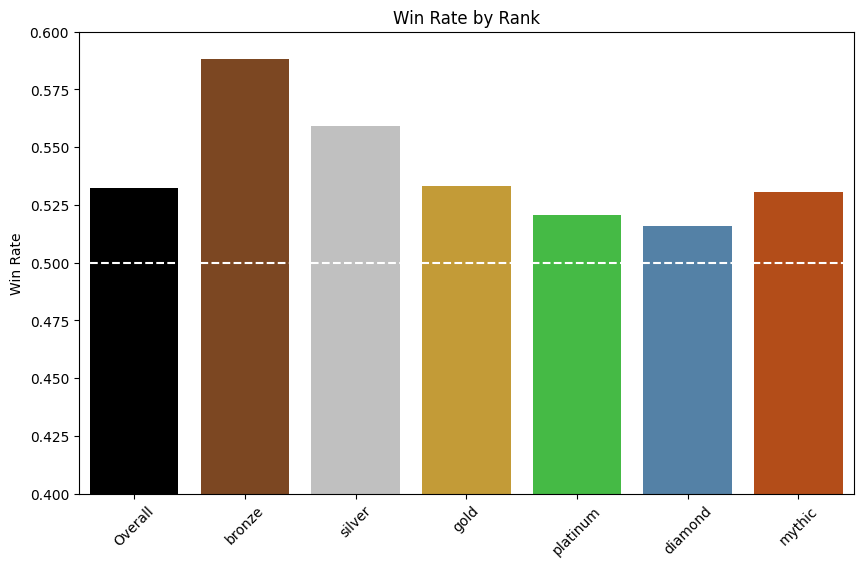

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define rank colors with correct ordering
rank_order = ['Overall', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'mythic']
rank_colors = {
    'bronze': '#8B4513',  # Brown
    'silver': '#C0C0C0',  # Gray
    'gold': '#DAA520',    # Gold
    'platinum': '#32CD32', # Green
    'diamond': '#4682B4', # Blue
    'mythic': '#CC4400',   # Orange-Red,
    'Overall': '#000000'  # Black for overall win rate
}

# Compute overall win rate
overall_win_rate = summary_df['wins'].sum() / (summary_df['wins'].sum() + summary_df['losses'].sum())

# Create DataFrame for visualization
rank_win_rates = summary_df.groupby('rank').agg(
    total_wins=('wins', 'sum'),
    total_losses=('losses', 'sum')
).reset_index()

rank_win_rates['win_rate'] = rank_win_rates['total_wins'] / (rank_win_rates['total_wins'] + rank_win_rates['total_losses'])

# Append overall win rate
overall_df = pd.DataFrame({'rank': ['Overall'], 'win_rate': [overall_win_rate]})
rank_win_rates = pd.concat([overall_df, rank_win_rates], ignore_index=True)

# Ensure correct rank order
rank_win_rates['rank'] = pd.Categorical(rank_win_rates['rank'], categories=rank_order, ordered=True)
rank_win_rates = rank_win_rates.sort_values('rank')

# Assign colors to ranks
rank_win_rates['color'] = rank_win_rates['rank'].map(rank_colors)

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x='rank', y='win_rate', data=rank_win_rates, palette=rank_win_rates['color'].tolist())

# Adjust y-axis range
plt.ylim(0.4, 0.6)

# Add a dashed white line at 0.5
plt.axhline(0.5, color='white', linestyle='dashed', linewidth=1.5)

plt.title('Win Rate by Rank')
plt.ylabel('Win Rate')
plt.xlabel('')
plt.xticks(rotation=45)

plt.show()


## Important Note

This is surprising, but also makes sense as we consider the matchmaking system. MTG Arena does partial resets of player rankings for each set. Accounting for

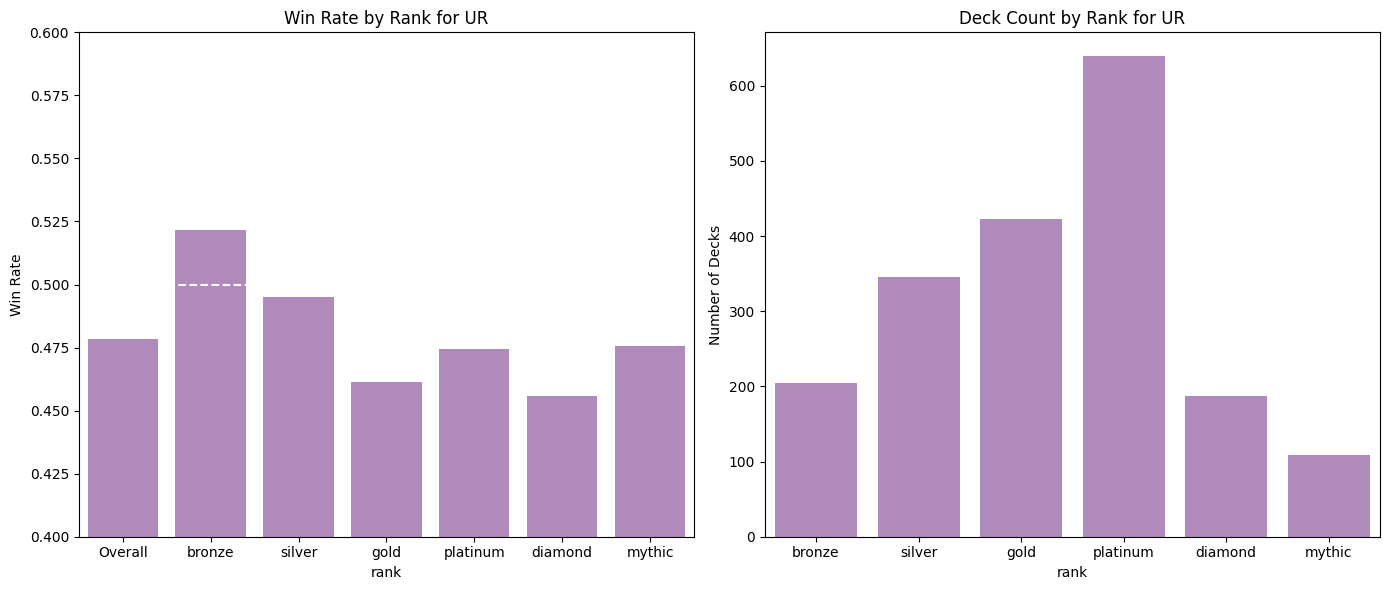

In [ ]:
def plot_color_analysis(color_combo, graph_color):
    """Visualize win rate and deck count for a given color combination."""
    
    # Filter dataset for the specific color combination
    color_df = summary_df[summary_df['main_colors'] == color_combo]
    
    # Compute win rate per rank
    rank_win_rates = color_df.groupby('rank').agg(
        total_wins=('wins', 'sum'),
        total_losses=('losses', 'sum')
    ).reset_index()
    
    rank_win_rates['win_rate'] = rank_win_rates['total_wins'] / (rank_win_rates['total_wins'] + rank_win_rates['total_losses'])

    # Compute overall win rate for this color combination
    overall_win_rate = color_df['wins'].sum() / (color_df['wins'].sum() + color_df['losses'].sum())
    
    overall_df = pd.DataFrame({'rank': ['Overall'], 'win_rate': [overall_win_rate]})
    rank_win_rates = pd.concat([overall_df, rank_win_rates], ignore_index=True)

    # Compute deck count per rank
    rank_counts = color_df['rank'].value_counts().reset_index()
    rank_counts.columns = ['rank', 'count']

    # Ensure ranks are ordered correctly
    rank_order = ['Overall', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'mythic']
    rank_win_rates['rank'] = pd.Categorical(rank_win_rates['rank'], categories=rank_order, ordered=True)
    rank_counts['rank'] = pd.Categorical(rank_counts['rank'], categories=rank_order[1:], ordered=True)  # Exclude 'Overall'
    
    rank_win_rates = rank_win_rates.sort_values('rank')
    rank_counts = rank_counts.sort_values('rank')

    # Plot the graphs side by side
    _, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Win rate graph
    sns.barplot(x='rank', y='win_rate', data=rank_win_rates, color=graph_color, ax=axes[0])
    axes[0].set_title(f'Win Rate by Rank for {color_combo}')
    axes[0].set_ylim(0.4, 0.6)
    axes[0].axhline(0.5, color='white', linestyle='dashed', linewidth=1.5)
    axes[0].set_ylabel('Win Rate')

    # Deck count graph
    sns.barplot(x='rank', y='count', data=rank_counts, color=graph_color, ax=axes[1])
    axes[1].set_title(f'Deck Count by Rank for {color_combo}')
    axes[1].set_ylabel('Number of Decks')

    plt.tight_layout()
    plt.show()

plot_color_analysis('UR', '#B682C4')

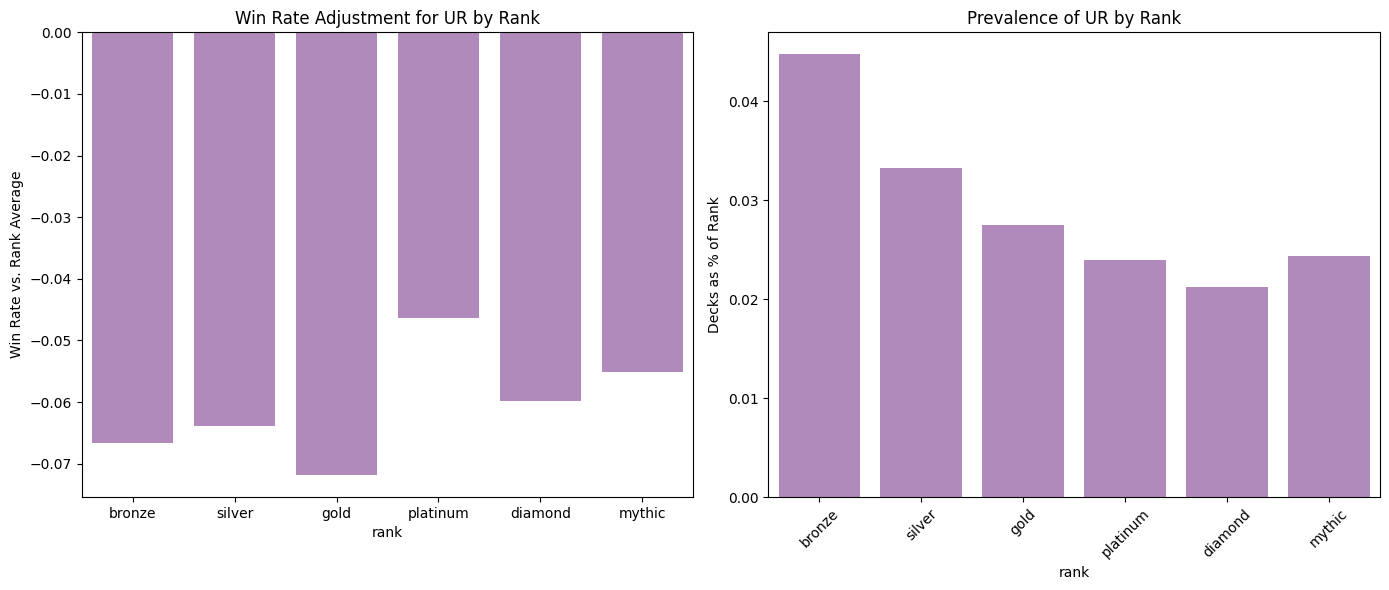

In [34]:
def normalize_color_performance(color_combo, graph_color):
    """Visualizes corrected win rate and deck prevalence for a color combo."""
    
    # Filter dataset for the specific color combination
    color_df = summary_df[summary_df['main_colors'] == color_combo]

    # Compute deck prevalence correction
    total_rank_counts = summary_df['rank'].value_counts().reset_index()
    total_rank_counts.columns = ['rank', 'total_decks']
    color_rank_counts = color_df['rank'].value_counts().reset_index()
    color_rank_counts.columns = ['rank', 'color_decks']

    rank_prevalence = pd.merge(color_rank_counts, total_rank_counts, on='rank', how='left')
    rank_prevalence['normalized_prevalence'] = rank_prevalence['color_decks'] / rank_prevalence['total_decks']

    # Compute win rate correction
    rank_win_rates = color_df.groupby('rank').agg(
        total_wins=('wins', 'sum'),
        total_losses=('losses', 'sum')
    ).reset_index()
    rank_win_rates['color_win_rate'] = rank_win_rates['total_wins'] / (rank_win_rates['total_wins'] + rank_win_rates['total_losses'])

    overall_win_rates = summary_df.groupby('rank').agg(
        total_wins=('wins', 'sum'),
        total_losses=('losses', 'sum')
    ).reset_index()
    overall_win_rates['overall_win_rate'] = overall_win_rates['total_wins'] / (overall_win_rates['total_wins'] + overall_win_rates['total_losses'])

    rank_win_correction = pd.merge(rank_win_rates, overall_win_rates[['rank', 'overall_win_rate']], on='rank', how='left')
    rank_win_correction['win_rate_adjusted'] = rank_win_correction['color_win_rate'] - rank_win_correction['overall_win_rate']

    # Ensure correct rank ordering
    rank_order = ['bronze', 'silver', 'gold', 'platinum', 'diamond', 'mythic']
    rank_prevalence['rank'] = pd.Categorical(rank_prevalence['rank'], categories=rank_order, ordered=True)
    rank_win_correction['rank'] = pd.Categorical(rank_win_correction['rank'], categories=rank_order, ordered=True)

    rank_prevalence = rank_prevalence.sort_values('rank')
    rank_win_correction = rank_win_correction.sort_values('rank')

    # Plot the graphs side by side (Win Rate on the Left, Prevalence on the Right)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Win rate correction graph (left)
    sns.barplot(x='rank', y='win_rate_adjusted', data=rank_win_correction, color=graph_color, ax=axes[0])
    axes[0].set_title(f'Win Rate Adjustment for {color_combo} by Rank')
    axes[0].axhline(0, color='white', linestyle='dashed', linewidth=1.5)  # Baseline at 0 (neutral performance)
    axes[0].set_ylabel('Win Rate vs. Rank Average')

    # Prevalence graph (right)
    sns.barplot(x='rank', y='normalized_prevalence', data=rank_prevalence, color=graph_color, ax=axes[1])
    axes[1].set_title(f'Prevalence of {color_combo} by Rank')
    axes[1].set_ylabel('Decks as % of Rank')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

normalize_color_performance('UR', '#B682C4')

ValueError: Could not interpret value `win_rate_adjusted` for `y`. An entry with this name does not appear in `data`.

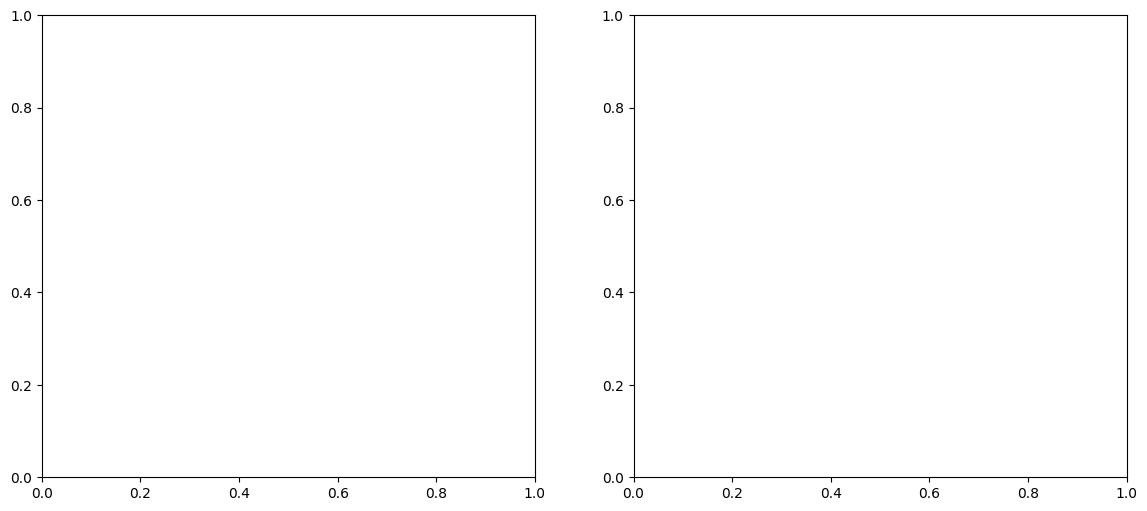

In [ ]:
#TODO fix broken

def analyze_color_performance(color_combo, graph_color, normalize=False):
    """Visualizes win rate and deck prevalence for a color combination with optional normalization."""

    # Filter dataset for the specific color combination
    color_df = summary_df[summary_df['main_colors'] == color_combo]

    # Compute deck count per rank
    color_rank_counts = color_df['rank'].value_counts().reset_index()
    color_rank_counts.columns = ['rank', 'color_decks']

    # Compute win rate per rank
    rank_win_rates = color_df.groupby('rank').agg(
        total_wins=('wins', 'sum'),
        total_losses=('losses', 'sum')
    ).reset_index()
    rank_win_rates['color_win_rate'] = rank_win_rates['total_wins'] / (rank_win_rates['total_wins'] + rank_win_rates['total_losses'])

    if normalize:
        # Compute total deck counts per rank (for prevalence correction)
        total_rank_counts = summary_df['rank'].value_counts().reset_index()
        total_rank_counts.columns = ['rank', 'total_decks']

        # Merge with total rank counts to normalize deck prevalence
        rank_prevalence = pd.merge(color_rank_counts, total_rank_counts, on='rank', how='left')
        rank_prevalence['normalized_prevalence'] = rank_prevalence['color_decks'] / rank_prevalence['total_decks']

        # Compute overall win rate per rank (for comparison)
        overall_win_rates = summary_df.groupby('rank').agg(
            total_wins=('wins', 'sum'),
            total_losses=('losses', 'sum')
        ).reset_index()
        overall_win_rates['overall_win_rate'] = overall_win_rates['total_wins'] / (overall_win_rates['total_wins'] + overall_win_rates['total_losses'])

        # Merge win rates for normalization
        rank_win_correction = pd.merge(rank_win_rates, overall_win_rates[['rank', 'overall_win_rate']], on='rank', how='left')
        rank_win_correction['win_rate_adjusted'] = rank_win_correction['color_win_rate'] - rank_win_correction['overall_win_rate']
    else:
        # Compute overall win rate for this color combination (non-normalized mode)
        overall_win_rate = color_df['wins'].sum() / (color_df['wins'].sum() + color_df['losses'].sum())
        overall_df = pd.DataFrame({'rank': ['Overall'], 'win_rate': [overall_win_rate]})
        rank_win_rates = pd.concat([overall_df, rank_win_rates], ignore_index=True)

        rank_prevalence = color_rank_counts.copy()  # No normalization needed

    # Ensure correct rank ordering
    rank_order = ['bronze', 'silver', 'gold', 'platinum', 'diamond', 'mythic']
    rank_prevalence['rank'] = pd.Categorical(rank_prevalence['rank'], categories=rank_order, ordered=True)
    rank_win_rates['rank'] = pd.Categorical(rank_win_rates['rank'], categories=rank_order if not normalize else rank_order, ordered=True)

    rank_prevalence = rank_prevalence.sort_values('rank')
    rank_win_rates = rank_win_rates.sort_values('rank')

    # Plot the graphs side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Win rate graph (left)
    sns.barplot(x='rank', y='win_rate_adjusted' if normalize else 'color_win_rate', data=rank_win_rates, color=graph_color, ax=axes[0])
    axes[0].set_title(f'{"Adjusted" if normalize else "Raw"} Win Rate for {color_combo}')
    if normalize:
        axes[0].axhline(0, color='white', linestyle='dashed', linewidth=1.5)  # Baseline at 0 for normalized win rate
        axes[0].set_ylabel('Win Rate vs. Rank Average')
    else:
        axes[0].axhline(0.5, color='white', linestyle='dashed', linewidth=1.5)  # Baseline at 50% win rate
        axes[0].set_ylabel('Win Rate')

    # Prevalence graph (right)
    sns.barplot(x='rank', y='normalized_prevalence' if normalize else 'color_decks', data=rank_prevalence, color=graph_color, ax=axes[1])
    axes[1].set_title(f'{"Normalized" if normalize else "Raw"} Prevalence of {color_combo}')
    axes[1].set_ylabel('Decks as % of Rank' if normalize else 'Deck Count')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#analyze_color_performance('UR', '#B682C4', normalize=True)

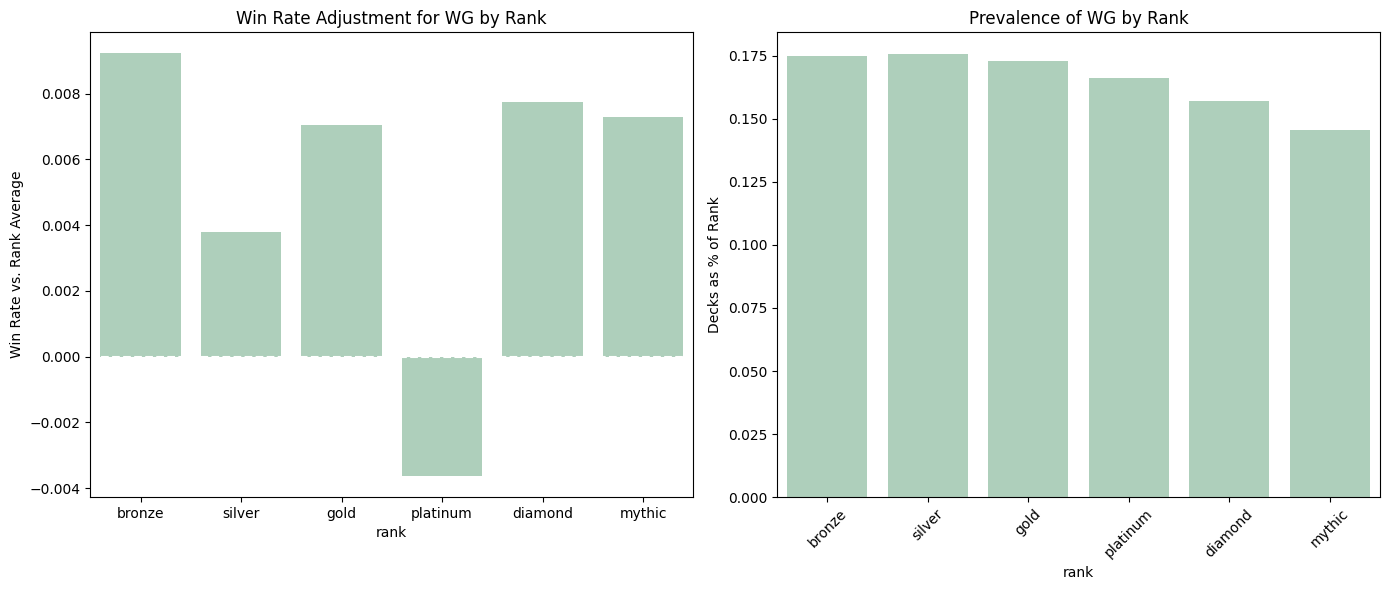

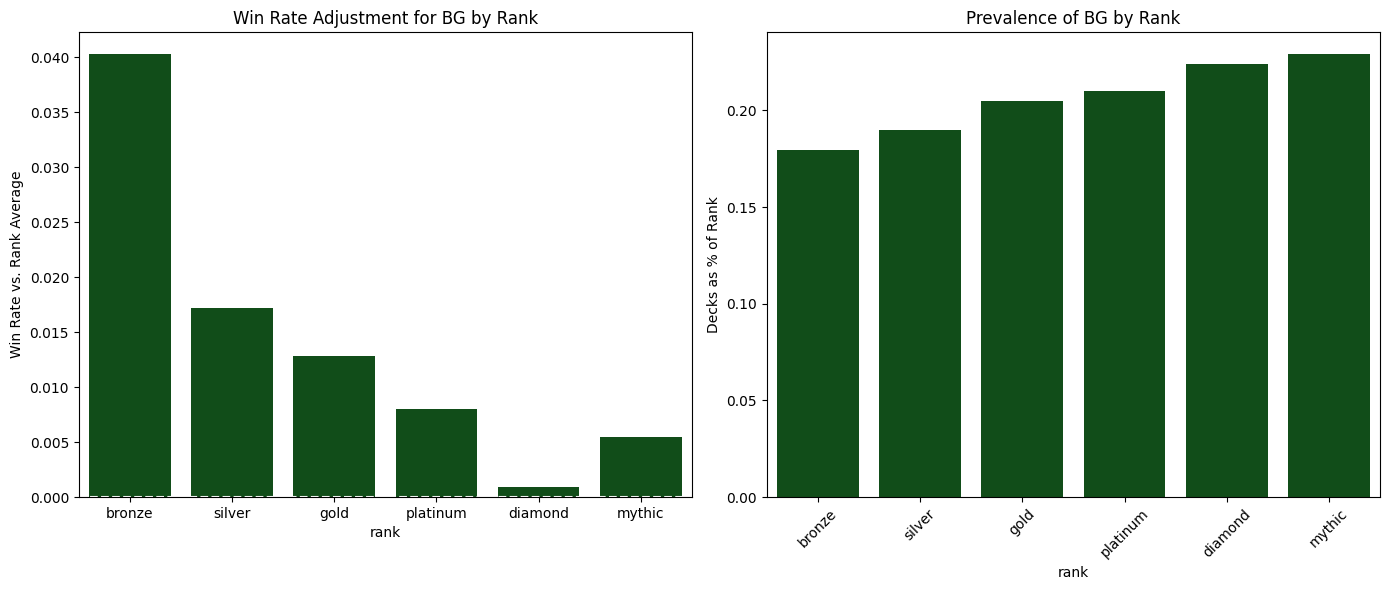

In [36]:
normalize_color_performance('WG', '#A8D5BA')
normalize_color_performance('BG', "#075712")